In [1]:
import numpy as np
import pymc as pm
import pytensor.tensor as pt
import pytensor
import matplotlib.pyplot as plt
import arviz as az
import blackjax
from numba import njit
import os
import sys
import time
import errno
import timeit

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
az.style.use("arviz-darkgrid")
colors_l = ["#A4C3D9", "#7B9DBF", "#52779F", "#2A537E"]

In [7]:
A = np.array([[-1, 0.6], [0, -1]])
C = np.array([0, 0.5])
A1, A2, A3, A4 = A[0, 0], A[0, 1], A[1, 0], A[1, 1]
C1, C2 = C[0], C[1]
kappa = 1.92   # Neural decay.
gamma = 0.41   # Autoregulation of blood flow.
alpha = 0.32   # Stiffness parameter (outflow = volume^(1/alpha))
E0 = 0.34      # Resting oxygen extraction fraction
tau = 2.66     # Transit time (seconds)
k1 = 7. * E0
k2 = 2.
k3 = 2. * E0 - 0.2
V0 = 0.02      # Resting blood volume fraction

theta_true = np.array([A1, A2, A3, A4, C1, C2, kappa, gamma, alpha, E0, tau, k1, k2, k3, V0])
my_var_names = ['A1', 'A2', 'A3', 'A4', 'C1', 'C2', 'kappa', 'gamma', 'alpha', 'E0', 'tau', 'k1', 'k2', 'k3', 'V0']

t0 = 0.0
tend = 200.0
dt = 0.1
ts = np.arange(t0, tend + dt, dt)
n_steps = len(ts)

num_node = 2
x0 = np.zeros(num_node)   # neural state
s0 = np.zeros(num_node)   # vasodilatory signal
f0 = np.ones(num_node)    # blood flow
v0 = np.ones(num_node)    # blood volume
q0 = np.ones(num_node)    # deoxyhemoglobin content

#t0 = np.ones(num_node)



init_state = np.concatenate([x0, s0, f0, v0, q0])  # shape: (5*num_node,)

In [9]:
def stim_boxcar_pytensor(t, onsets, durations, amplitudes):
    """Boxcar stimulus function compatible with PyTensor"""
    u_t = 0
    for i in range(len(onsets)):
        u_t += pt.switch(pt.and_(t >= onsets[i], t <= (onsets[i] + durations[i])), amplitudes[i], 0)
    return u_t

#u     = stim_boxcar_pytensor(np.arange(200), [0],[10],[1])

Sampling: []


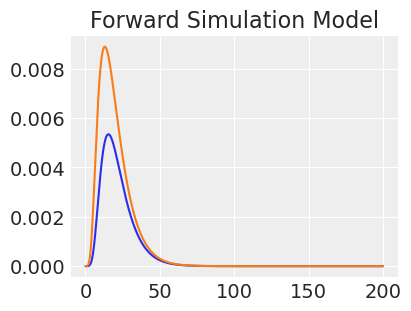

In [19]:
def model_scan_simulation(theta,  onsets, durations, amplitudes, num_node, dt=0.1):
    with pm.Model() as model:
        A1, A2, A3, A4, C1, C2, kappa, gamma, alpha, E0, tau, k1, k2, k3, V0 = theta

        def ode_update_function(t, state, A1, A2, A3, A4, C1, C2, kappa, gamma, alpha, E0, tau, k1, k2, k3, V0):
            
            x = state[0:num_node]
            s = state[num_node:2*num_node]
            f = state[2*num_node:3*num_node]
            v = state[3*num_node:4*num_node]
            q = state[4*num_node:5*num_node]
            
            stimulus = stim_boxcar_pytensor(t, onsets, durations, amplitudes)
            A_mat = pt.stack([[A1, A2], [A3, A4]])
            C_vec = pt.stack([C1, C2])
            #stimulus = 
            dx_dt = pt.dot(A_mat, x) + C_vec * stimulus
            new_x = x + dt * dx_dt

            # Hemodynamic state updates (using the Runge-Kutta method)
            s_k1 = x - kappa * s - gamma * (f - 1)
            f_k1 = s
            v_k1 = (1 / tau) * (f - v ** (1 / alpha))
            q_k1 =  (1 / tau) * (((f * (1 - (1 - E0) ** (1 / f))) / E0) - q * v ** (1 / alpha - 1))

            # Compute intermediate values (Euler method)
            s_a = s + s_k1 * dt
            f_a = f + f_k1 * dt
            v_a = v + v_k1 * dt
            q_a = q + q_k1 * dt

            # 2nd order increments (RK2 method)
            #s_k2 = x - kappa * s_a - gamma * (f_a - 1)
            #f_k2 = s_a
            #v_k2 = (1 / tau) * (f_a - v_a ** (1 / alpha))
            #q_k2 = (1 / tau) * (((f_a * (1 - (1 - E0) ** (1 / f_a))) / E0) - q_a * v_a ** (1 / alpha - 1))
#
            ## Update states using RK2
            #s_new = s + 0.5 * (s_k1 + s_k2) * dt
            #f_new = f + 0.5 * (f_k1 + f_k2) * dt
            #v_new = v + 0.5 * (v_k1 + v_k2) * dt
            #q_new = q + 0.5 * (q_k1 + q_k2) * dt
            #new_state = pt.concatenate([new_x, s_new, f_new, v_new, q_new])
            new_state = pt.concatenate([new_x, s_a, f_a, v_a, q_a])
            return new_state

        init_state_tensor = pt.as_tensor_variable(init_state)
        t_vals = pt.arange(n_steps, dtype="float64")
        result, updates = pytensor.scan(
            fn=ode_update_function,
            sequences=[t_vals],  
            outputs_info= [init_state_tensor],
            non_sequences=[A1, A2, A3, A4, C1, C2, kappa, gamma, alpha, E0, tau, k1, k2, k3, V0],
            n_steps=n_steps
        )

        f_result = result[:, 2*num_node:3*num_node]
        v_result = result[:, 3*num_node:4*num_node]
        q_result = result[:, 4*num_node:5*num_node]
        bold = V0 * (k1 * (1 - q_result) + k2 * (1 - q_result/v_result) + k3 * (1 - v_result))

        

        # Save the computed BOLD signal as a deterministic variable.
        pm.Deterministic("bold",  bold)
        
    return model

# Example of creating the model:
model = model_scan_simulation(theta_true,[0],[30],[1], num_node, dt=0.05)

fig, ax = plt.subplots(figsize=(4, 3))
with model:
    # Sample prior predictive to get the BOLD signal
    simul = pm.sample_prior_predictive(1).prior.bold[0][0].values
    ax.plot(ts, simul)
    #bold_signal = prior_predictive["BOLD"][0]  # Extract BOLD signal from the sampled prior

ax.set_title("Forward Simulation Model");

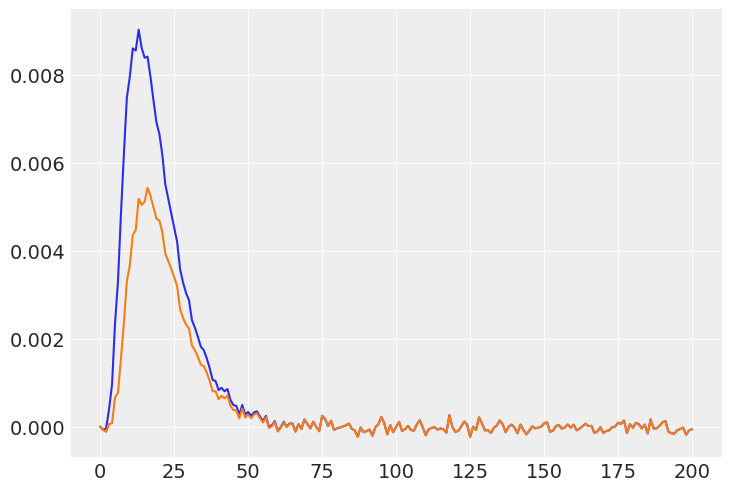

In [21]:
data = simul[:,0]
data2 = simul[:,1]
ds=10
ts_obs=ts[::ds]
xpy_ds=data[::ds].flatten()
xpy_ds2=data2[::ds].flatten()

sigma_true=0.0001
x_noise = np.random.normal(loc=0, scale=sigma_true, size=xpy_ds.shape[0])

xpy_obs = xpy_ds + x_noise
xpy_obs2 = xpy_ds2 + x_noise

plt.plot(np.arange(201), xpy_obs2)
plt.plot(np.arange(201), xpy_obs)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15548\1127557390.py:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout();


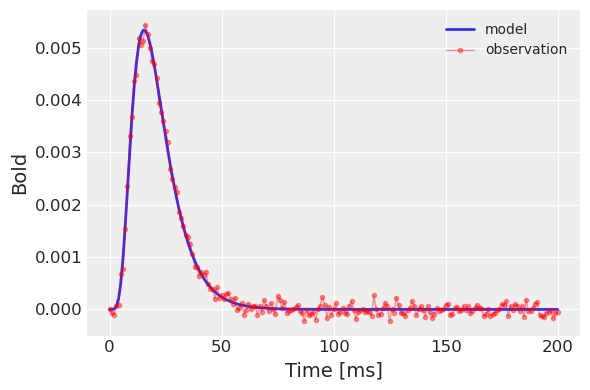

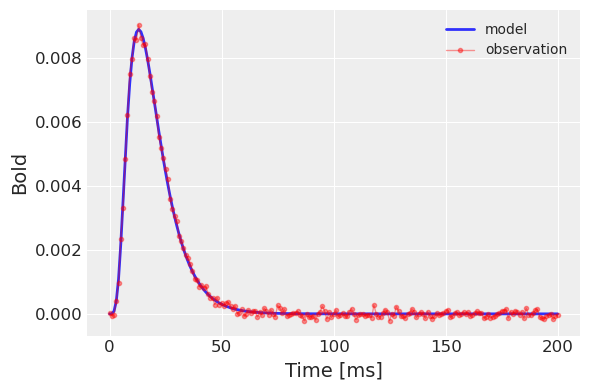

In [23]:
def plot_observation(ts_model, xpy_model, ts_obs, xpy_obs):
    plt.figure(figsize=(6,4))
    plt.plot(ts_model, xpy_model, color="b", lw=2,  alpha=0.8, label='model');
    plt.plot(ts_obs, xpy_obs, color="red", lw=1, marker=".", alpha=0.4, label='observation');
    plt.legend(fontsize=10, frameon=False, loc='upper right')
    plt.ylabel('Bold', fontsize=14); 
    plt.xlabel('Time [ms]', fontsize=14); 
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout();
    #plt.savefig(os.path.join((output_dir),"Observation.png"), dpi=800)

plot_observation(ts_obs, xpy_ds, ts_obs, xpy_obs);
plot_observation(ts_obs, xpy_ds2, ts_obs, xpy_obs2);

In [25]:
data_array = np.array([xpy_obs,xpy_obs2]).T

In [31]:
means=np.array([-1,0.6,0,-1,                 0,     0.5,                           1.92, 0.41,   0.32, 0.34, 2.66 ])
sigg=np.array([1/8,1/8,0.0000001,1/8,       0.0000001,1/8,      1/16, 1/16,  1/16, 1/16, 1/16])
#var=np.array([0.0000001,0.0000001,0.0000001,0.0000001,       0.0000001,0.0000001,      0.0000001, 0.0000001,  0.0000001, 0.0000001, 0.0000001])

In [33]:
prior_specs = dict(means=np.array(means), sigma=np.array(sigg))

In [ ]:
theta_true = np.array([A1, A2, A3, A4, C1, C2, kappa, gamma, alpha, E0, tau, k1, k2, k3, V0])
my_var_names = ['A1', 'A2', 'A3', 'A4', 'C1', 'C2', 'kappa', 'gamma', 'alpha', 'E0', 'tau', 'k1', 'k2', 'k3', 'V0']

In [29]:
theta_true

array([-1.  ,  0.6 ,  0.  , -1.  ,  0.  ,  0.5 ,  1.92,  0.41,  0.32,
        0.34,  2.66,  2.38,  2.  ,  0.48,  0.02])

In [47]:
def model_scan_inference(data, prior_specs,onsets, durations, amplitudes, num_node, dt=0.1):
    with pm.Model() as model:
        
        A1 =pm.Normal("A1", mu=prior_specs['means'][0], sigma=prior_specs['sigma'][0])
        A2 =pm.Normal("A2", mu=prior_specs['means'][1], sigma=prior_specs['sigma'][1])
        A3 =pm.Normal("A3", mu=prior_specs['means'][2], sigma=prior_specs['sigma'][2])
        A4 =pm.Normal("A4", mu=prior_specs['means'][3], sigma=prior_specs['sigma'][3])
        C1 =pm.Normal("C1", mu=prior_specs['means'][4], sigma=prior_specs['sigma'][4])
        C2 =pm.Normal("C2", mu=prior_specs['means'][5], sigma=prior_specs['sigma'][5])
        
        kappa =pm.Normal("kappa", mu=prior_specs['means'][6], sigma=prior_specs['sigma'][6])
        gamma =pm.Normal("gamma", mu=prior_specs['means'][7], sigma=prior_specs['sigma'][7])
        alpha =pm.Normal("alpha", mu=prior_specs['means'][8], sigma=prior_specs['sigma'][8])
        E0 =pm.Normal("E0", mu=prior_specs['means'][9], sigma=prior_specs['sigma'][9])
        tau =pm.Normal("tau", mu=prior_specs['means'][10], sigma=prior_specs['sigma'][10])
        
        
        
        #k1,k2,k3,V0 = constant
        k1 = 7. * E0
        k2 = 2.
        k3 = 2. * E0 - 0.2
        V0 = 0.02      # Resting blood volume fraction


        def ode_update_function(t, state, A1, A2, A3, A4, C1, C2, kappa, gamma, alpha, E0, tau, k1, k2, k3, V0):
            
            x = state[0:num_node]
            s = state[num_node:2*num_node]
            f = state[2*num_node:3*num_node]
            v = state[3*num_node:4*num_node]
            q = state[4*num_node:5*num_node]
            
            stimulus = stim_boxcar_pytensor(t, onsets, durations, amplitudes)
            A_mat = pt.stack([[A1, A2], [A3, A4]])
            C_vec = pt.stack([C1, C2])
            #stimulus = 
            dx_dt = pt.dot(A_mat, x) + C_vec * stimulus
            new_x = x + dt * dx_dt

            # Hemodynamic state updates (using the Runge-Kutta method)
            s_k1 = x - kappa * s - gamma * (f - 1)
            f_k1 = s
            v_k1 = (1 / tau) * (f - v ** (1 / alpha))
            q_k1 =  (1 / tau) * (((f * (1 - (1 - E0) ** (1 / f))) / E0) - q * v ** (1 / alpha - 1))

            # Compute intermediate values (Euler method)
            s_a = s + s_k1 * dt
            f_a = f + f_k1 * dt
            v_a = v + v_k1 * dt
            q_a = q + q_k1 * dt

            #f_a = pt.maximum(f_a, 1e-5)
            #q_a = pt.maximum(q_a, 1e-5)
            #v_a = pt.maximum(v_a, 1e-5)

            new_state = pt.concatenate([new_x, s_a, f_a, v_a, q_a])
            return new_state

        init_state_tensor = pt.as_tensor_variable(init_state)
        t_vals = pt.arange(n_steps, dtype="float64")
        result, updates = pytensor.scan(
            fn=ode_update_function,
            sequences=[t_vals],  
            outputs_info= [init_state_tensor],
            non_sequences=[A1, A2, A3, A4, C1, C2, kappa, gamma, alpha, E0, tau, k1, k2, k3, V0],
            n_steps=n_steps
        )

        f_result = result[:, 2*num_node:3*num_node]
        v_result = result[:, 3*num_node:4*num_node]
        q_result = result[:, 4*num_node:5*num_node]
        bold = V0 * (k1 * (1 - q_result) + k2 * (1 - q_result/v_result) + k3 * (1 - v_result))

        

        # Save the computed BOLD signal as a deterministic variable.
        pm.Deterministic("bold",  bold)
        xpy_model = pm.Deterministic("xpy_model", bold[::ds])
        #xpy_model = pm.Deterministic("xpy_model", bold)
                # Likelihood function
        pm.Normal("xpy_obs", mu=xpy_model, sigma=0.1, observed=data_array)

        
    return model


In [49]:
model = model_scan_inference(data_array, prior_specs,[0],[30],[1], num_node, dt=0.05)

In [51]:
n_ = 100
with model :
    prior_pred = pm.sample_prior_predictive(samples=n_)

Sampling: [A1, A2, A3, A4, C1, C2, E0, alpha, gamma, kappa, tau, xpy_obs]


C:\Users\ASUS\AppData\Local\Temp\ipykernel_15548\1906062760.py:15: UserWarning: The figure layout has changed to tight
  plt.tight_layout();


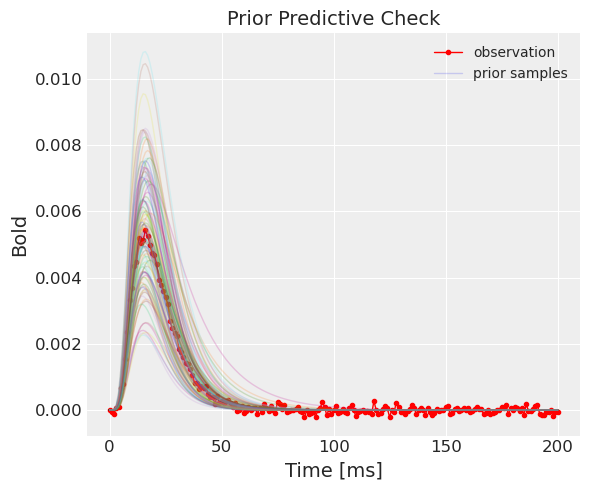

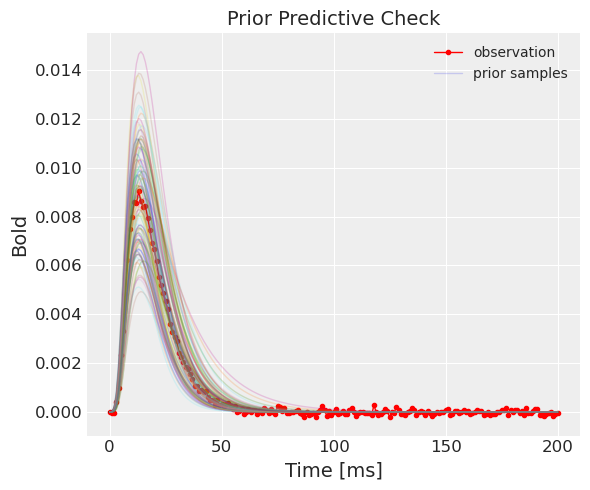

In [52]:
prior_predictions = {'xpy_model': az.extract(prior_pred.prior['xpy_model']).to_array().values.squeeze().T}
def plot_priorcheck(ts_obs, xpy_obs, prior_predictions, n_, title,num_node):
    for j in range(num_node):
        plt.figure(figsize=(6, 5))
        plt.plot(ts_obs, xpy_obs[:,j] ,'.-', color='r', lw=1, label='observation');
        for i in range(n_):
            plt.plot(prior_predictions['xpy_model'][i,j,:], lw=1, alpha=0.2)
        plt.plot(ts_obs, prior_predictions['xpy_model'][i,j,:], lw=1, alpha=0.2, label='prior samples')    
        plt.title(title, fontsize=14)
        plt.legend(fontsize=10, frameon=False, loc='upper right')
        plt.ylabel('Bold', fontsize=14); 
        plt.xlabel('Time [ms]', fontsize=14); 
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.tight_layout();
    
title='Prior Predictive Check'
plot_priorcheck(ts_obs, data_array, prior_predictions, n_, title,2);

In [58]:
#prior_predictions

## Model_inversion: HMC sampling

In [71]:
tune, draws, n_chains = 200, 200, 2

In [73]:
start_time = time.time()
with model:
    trace_nuts_pytensor_scan = pm.sample(nuts_sampler="pymc", 
                                                  tune=tune, 
                                                  draws=draws, 
                                                  chains=n_chains,
                                                  target_accept=0.9,
                                                  progressbar=True)
crudetime_nuts_pytensor_scan = time.time() - start_time
print("---running took: %s seconds ---" % crudetime_nuts_pytensor_scan_blackjax)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A1, A2, A3, A4, C1, C2, kappa, gamma, alpha, E0, tau]


Output()

Sampling 2 chains for 200 tune and 200 draw iterations (400 + 400 draws total) took 51737 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


---running took: 51800.07726788521 seconds ---


In [74]:
az_obj = trace_nuts_pytensor_scan_blackjax
az.summary(az_obj, var_names=['A1','A2', 'A3', 'A4', 'C1', 'C2', 'kappa', 'gamma', 'alpha', 'E0', 'tau'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
A1,-0.987,0.122,-1.200,-0.747,0.006,0.004,436.0,239.0,1.02
A2,0.369,0.371,-0.012,0.836,0.255,0.213,2.0,12.0,2.64
A3,0.000,0.000,-0.000,0.000,0.000,0.000,391.0,185.0,1.01
A4,-1.319,0.335,-1.672,-0.856,0.226,0.190,3.0,33.0,1.84
C1,-0.000,0.000,-0.000,0.000,0.000,0.000,392.0,179.0,1.02
C2,0.765,0.157,0.524,0.987,0.104,0.087,3.0,15.0,2.17
kappa,1.922,0.064,1.817,2.049,0.003,0.002,616.0,292.0,1.00
gamma,0.412,0.063,0.286,0.528,0.003,0.002,496.0,94.0,1.03
alpha,0.318,0.061,0.209,0.435,0.003,0.002,451.0,237.0,1.01
E0,0.342,0.063,0.222,0.458,0.005,0.003,168.0,241.0,1.01


C:\Users\ASUS\AppData\Local\Temp\ipykernel_15548\2238489735.py:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout();


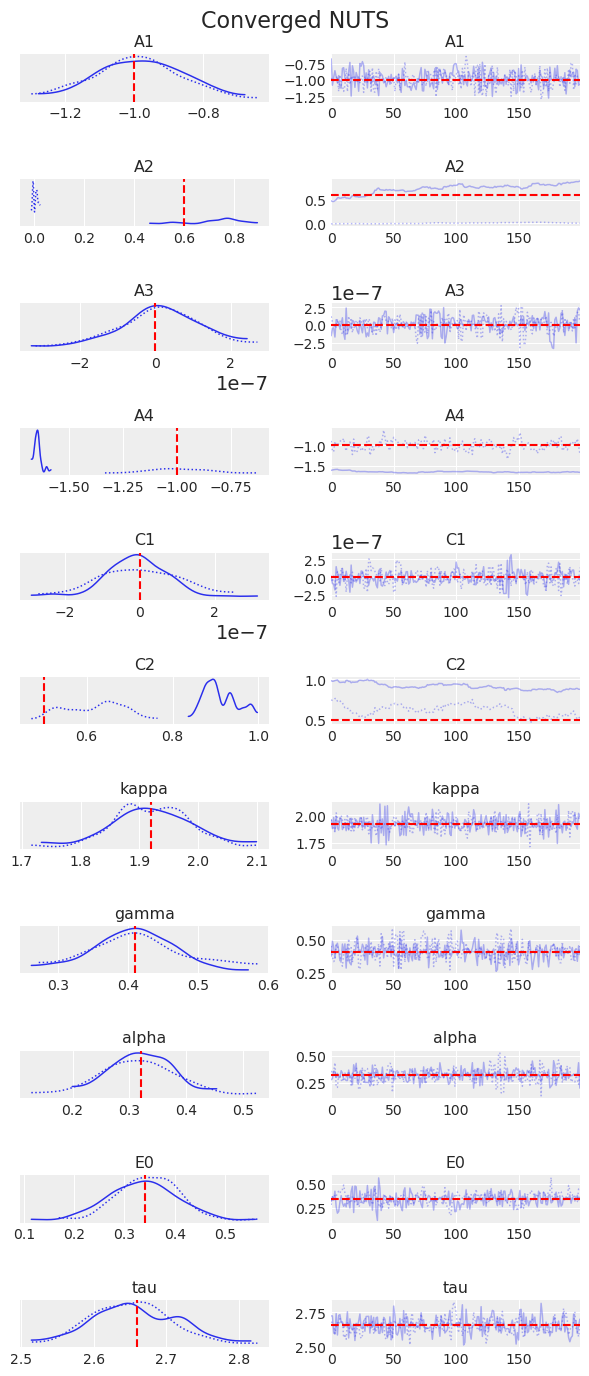

In [75]:
axes = az.plot_trace(
    az_obj,
    var_names=['A1','A2', 'A3', 'A4', 'C1', 'C2', 'kappa', 'gamma', 'alpha', 'E0', 'tau'],
    compact=True,
    kind="trace",
    backend_kwargs={"figsize": (6, 14), "layout": "constrained"},)

for ax, true_val in zip(axes[:, 0], theta_true):
    ax.axvline(x=true_val, color='red', linestyle='--')  
for ax, true_val in zip(axes[:, 1], theta_true):
    ax.axhline(y=true_val, color='red', linestyle='--')
    
plt.gcf().suptitle("Converged NUTS", fontsize=16)
plt.tight_layout();